<a href="https://colab.research.google.com/github/dnezan/km-sku-prediction/blob/main/KM_forecast_main_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **KwickMetrics Forecast Practice**
Dinesh Sreekanthan<br>
https://github.com/dnezan/km-sku-prediction

# Data Overview
The dataset has 3 columns
<br>
*   SKU ID
*   Date
*   Number of items sold that day

By using the function `=COUNTUNIQUE(A:A)` in Google Spreadsheets or `Dataframe.unique()` in Pandas, we can find the number of unique items being sold. <br>

**There are 3 unique items being sold over a period of about 67 months (2016-05-08 - 2021-12-06)**

# Setting up Cloud Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd "/content/drive/My Drive"

/content/drive/My Drive


In [3]:
!mkdir km-forecast-practice

mkdir: cannot create directory ‘km-forecast-practice’: File exists


In [4]:
%cd "/content/drive/My Drive/km-forecast-practice"

/content/drive/My Drive/km-forecast-practice


Make sure to move your dataset `km-forecast-practice.csv` to this folder.

In [5]:
!ls

'=4.0.0'
 amazon.com-2016-masked.csv
 amazon.com-2016-masked-datef.csv
 daily_data_processed.csv
 dataset-day-wise-amazon.com-masked2.csv
 dataset-day-wise-amazon.com-masked.gsheet
 dataset_new.csv
 dataset_new.gsheet
 frame_folder
 graph2.png
 graph3.png
 graph.svg
 graph_total.svg
 km-forecast-practice-data.csv
 my_awesome.gif
 OLDdataset-day-wise-amazon.com-masked.csv
 OLD_km-forecast-practice-data.csv
 requirements.txt
 results_1.gif
 results_2.gif
 results_3.gif
 results_4.gif
 results_5.gif
 temppp.csv
 traindate.csv
 traindate_z.csv


In [6]:
import pandas as pd
import csv
import datetime

dataset_name = 'dataset-day-wise-amazon.com-masked2.csv'
df=pd.read_csv(dataset_name)
df['timestamp']= pd.to_datetime(df['timestamp'])
print(df.dtypes)
df.head()

item_id               int64
timestamp    datetime64[ns]
demand                int64
dtype: object


,item_id,timestamp,demand
0,528,2016-05-08,0
1,528,2016-05-09,0
2,528,2016-05-10,0
3,528,2016-05-11,1
4,528,2016-05-12,2


# Preprocessing the Data
The first step is to rearrange the data so that we have each column representing a day and the rows containing the SKU ID. <br> 
We must also populate the data with missing dates, which we assume have 0 items sold on that day. So the first step is to add the missing dates, then set these as 0.

In [7]:
from dateutil.relativedelta import *

start_date=df.timestamp[0].date()  
end_date=df.timestamp.iat[-1].date()
start_sku=df.item_id[1]
print('Start date is',start_date)
print('End date is',end_date)
print("First SKU is",start_sku)

data = [[start_sku, 0]]

# Populating the new dataset with first row
df_new = pd.DataFrame(data, columns = ['SKU', start_date])
x = start_date

index = 2
var=0
num_months = (end_date.year - start_date.year) * 12 + (end_date.month - start_date.month)
num_days = (end_date-start_date).days

print("There are", num_months, "months between the two dates")
print("There are", num_days, "days between the two dates")

choice_num = input("Is your data daily or monthly? (d/m) ")
if (choice_num == 'd'):
  num_var = num_days
elif (choice_num == 'm'):
  num_var = num_months

while var<num_var:
  if (choice_num == 'd'):
    x+= datetime.timedelta(days=1)
  elif (choice_num == 'm'):
      x = x + relativedelta(months=+1)
  df_new.insert(loc=index, column=x, value=0)
  index+=1
  var+=1
year_mark = df_new
df_new.head()

Start date is 2016-05-08
End date is 2021-12-06
First SKU is 528
There are 67 months between the two dates
There are 2038 days between the two dates
Is your data daily or monthly? (d/m) d


,SKU,2016-05-08,2016-05-09,2016-05-10,2016-05-11,2016-05-12,2016-05-13,2016-05-14,2016-05-15,2016-05-16,2016-05-17,2016-05-18,2016-05-19,2016-05-20,2016-05-21,2016-05-22,2016-05-23,2016-05-24,2016-05-25,2016-05-26,2016-05-27,2016-05-28,2016-05-29,2016-05-30,2016-05-31,2016-06-01,2016-06-02,2016-06-03,2016-06-04,2016-06-05,2016-06-06,2016-06-07,2016-06-08,2016-06-09,2016-06-10,2016-06-11,2016-06-12,2016-06-13,2016-06-14,2016-06-15,...,2021-10-28,2021-10-29,2021-10-30,2021-10-31,2021-11-01,2021-11-02,2021-11-03,2021-11-04,2021-11-05,2021-11-06,2021-11-07,2021-11-08,2021-11-09,2021-11-10,2021-11-11,2021-11-12,2021-11-13,2021-11-14,2021-11-15,2021-11-16,2021-11-17,2021-11-18,2021-11-19,2021-11-20,2021-11-21,2021-11-22,2021-11-23,2021-11-24,2021-11-25,2021-11-26,2021-11-27,2021-11-28,2021-11-29,2021-11-30,2021-12-01,2021-12-02,2021-12-03,2021-12-04,2021-12-05,2021-12-06
0,528,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now we add all the unique products and populate the Dataframe with 0s. (Takes a few minutes to complete)

In [8]:
print(df_new.shape[1]) #number of columns

uniqval = list(df.item_id.unique()) #list of unique products
uniqval.pop(0)

x=0
while x < len(uniqval):
  listofzeros = [0] * (num_var + 1)
  listofzeros.insert(0, uniqval[x])
  df_length = len(df_new)
  df_new.loc[df_length] = listofzeros
  x+=1
  if(x%200==0):
    print(x)

print(df_new)

uniqval.insert(0,start_sku)

2040
    SKU  2016-05-08  2016-05-09  ...  2021-12-04  2021-12-05  2021-12-06
0   528           0           0  ...           0           0           0
1   529           0           0  ...           0           0           0
2  2336           0           0  ...           0           0           0

[3 rows x 2040 columns]


Next we fill in the values of items that were actually sold on a given day.

In [9]:
#Adding first product sales
count=-1

for y in uniqval:
  for x in df.item_id:
    if x == y: 
      count+=1
      z=df_new.columns.get_loc(pd.to_datetime(df.timestamp[count].date()).date())
      z1=df_new.index.get_loc(df_new.index[df_new['SKU'] == x][0])
      df_new.iloc[z1,z] = df.demand[count]
      
print("This product was sold on",count,"days")
df_new.head()

This product was sold on 5693 days


,SKU,2016-05-08,2016-05-09,2016-05-10,2016-05-11,2016-05-12,2016-05-13,2016-05-14,2016-05-15,2016-05-16,2016-05-17,2016-05-18,2016-05-19,2016-05-20,2016-05-21,2016-05-22,2016-05-23,2016-05-24,2016-05-25,2016-05-26,2016-05-27,2016-05-28,2016-05-29,2016-05-30,2016-05-31,2016-06-01,2016-06-02,2016-06-03,2016-06-04,2016-06-05,2016-06-06,2016-06-07,2016-06-08,2016-06-09,2016-06-10,2016-06-11,2016-06-12,2016-06-13,2016-06-14,2016-06-15,...,2021-10-28,2021-10-29,2021-10-30,2021-10-31,2021-11-01,2021-11-02,2021-11-03,2021-11-04,2021-11-05,2021-11-06,2021-11-07,2021-11-08,2021-11-09,2021-11-10,2021-11-11,2021-11-12,2021-11-13,2021-11-14,2021-11-15,2021-11-16,2021-11-17,2021-11-18,2021-11-19,2021-11-20,2021-11-21,2021-11-22,2021-11-23,2021-11-24,2021-11-25,2021-11-26,2021-11-27,2021-11-28,2021-11-29,2021-11-30,2021-12-01,2021-12-02,2021-12-03,2021-12-04,2021-12-05,2021-12-06
0,528,0,0,0,1,2,2,2,1,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,14,19,15,17,16,18,21,13,18,16,10,273,352,5,25,30,37,42,17,10,19,9,21,33,23,24,18,21,20,54,52,40,123,53,23,22,34,52,46,40
1,529,1,0,0,0,2,0,1,0,2,0,1,1,0,1,0,1,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,1,5,3,8,4,5,4,3,3,3,10,28,11,8,4,7,9,6,10,7,6,9,11,5,3,12,4,6,7,16,12,23,15,5,5,4,10,3,7
2,2336,0,0,1,0,0,0,1,1,0,1,2,0,1,0,0,1,2,1,0,0,1,0,0,0,1,1,0,0,0,0,20,40,0,1,2,0,0,2,0,...,24,19,16,20,23,23,21,23,19,17,28,24,37,23,29,35,33,41,37,38,39,42,39,33,41,53,49,33,37,86,84,67,84,57,18,18,49,62,59,39


In [10]:
df_new.to_csv('dataset_new.csv')

# Visualisation
Here we can visualise the sales of the first product in our dataset over a year.


In [11]:
import numpy as np 
from matplotlib import colors
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots


#Enter random SKU here
a=0
b=1
c=2

product_name_x = str(df_new.SKU[a])
product_name_y = str(df_new.SKU[b])
product_name_z = str(df_new.SKU[c])

sales_x = df_new.iloc[a].tolist()
del sales_x[0] #remove item_id
sales_y = df_new.iloc[b].tolist()
del sales_y[0] #remove item_id
sales_z = df_new.iloc[c].tolist()
del sales_z[0] #remove item_id
dates_list = df_new.columns.tolist()
del dates_list[0] #remove column name

df_x = pd.DataFrame(np.transpose([dates_list, sales_x]))
df_x.columns = ["ds", "y"]
df_x["ds"]= pd.to_datetime(df_x["ds"])
print("")
print(product_name_x)
print(df_x.head(6))

df_y = pd.DataFrame(np.transpose([dates_list, sales_y]))
df_y.columns = ["ds", "y"]
df_y["ds"]= pd.to_datetime(df_y["ds"])
print("")
print(product_name_y)
print(df_y.head(6))

df_z = pd.DataFrame(np.transpose([dates_list, sales_z]))
df_z.columns = ["ds", "y"]
df_z["ds"]= pd.to_datetime(df_z["ds"])
print("")
print(product_name_z)
print(df_z.head(6))

###PLOTLY
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.offline import iplot
import plotly.io as pio
pio.renderers.default='colab'

df_var = df_x

df_var['ds'] = pd.to_datetime(df_var['ds'])
weekly_df = df_var.resample('W', on='ds').apply(sum)
monthly_df = df_var.resample('M', on='ds').apply(sum)
daily_df = df_var.resample('D', on='ds').apply(sum)

colors = ["#ff3a3c", "#99c0f7", "#73e0e7", '#de5200']
fig = go.Figure()
fig.add_traces(go.Scatter(x=pd.to_datetime(monthly_df.index.values), y = monthly_df['y'], mode = 'lines', line=dict(color=colors[2]), name = 'Monthly Sales'))
fig.add_traces(go.Scatter(x=pd.to_datetime(weekly_df.index.values), y = weekly_df['y'], mode = 'lines', line=dict(color=colors[1]), name = 'Weekly Sales'))
fig.add_traces(go.Scatter(x=pd.to_datetime(daily_df.index.values), y = daily_df['y'], mode = 'lines', line=dict(color=colors[0]), name = 'Daily Sales'))
fig.update_layout(title = dict(text='Daily/Weekly/Monthly Sales for Product SKU '+product_name_x,x=0.5, font =dict(size=17, color = 'white')))
fig.update_layout(xaxis = {'title':'Year', 'color':'white'}, yaxis = {'title':'Demand', 'color':'white'}, paper_bgcolor='#1c1c28', plot_bgcolor='#28293d')
fig.update_layout(legend_font_color="white")
fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')
fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')

fig.show()

##SKU 2
df_var = df_y

df_var['ds'] = pd.to_datetime(df_var['ds'])
weekly_df = df_var.resample('W', on='ds').apply(sum)
monthly_df = df_var.resample('M', on='ds').apply(sum)
daily_df = df_var.resample('D', on='ds').apply(sum)

print("")

colors = px.colors.qualitative.Plotly
fig = go.Figure()
fig.add_traces(go.Scatter(x=pd.to_datetime(monthly_df.index.values), y = monthly_df['y'], mode = 'lines', line=dict(color=colors[2]), name = 'Monthly Sales'))
fig.add_traces(go.Scatter(x=pd.to_datetime(weekly_df.index.values), y = weekly_df['y'], mode = 'lines', line=dict(color=colors[1]), name = 'Weekly Sales'))
fig.add_traces(go.Scatter(x=pd.to_datetime(daily_df.index.values), y = daily_df['y'], mode = 'lines', line=dict(color=colors[0]), name = 'Daily Sales'))
fig.update_layout(title = dict(text='Daily/Weekly/Monthly Sales for Product SKU '+product_name_y,x=0.5, font =dict(size=17, color = 'white')))
fig.update_layout(xaxis = {'title':'Year', 'color':'white'}, yaxis = {'title':'Demand', 'color':'white'}, paper_bgcolor='#1c1c28', plot_bgcolor='#28293d')
fig.update_layout(legend_font_color="white")
fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')
fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')

fig.show()

##SKU3
df_var = df_z

df_var['ds'] = pd.to_datetime(df_var['ds'])
weekly_df = df_var.resample('W', on='ds').apply(sum)
monthly_df = df_var.resample('M', on='ds').apply(sum)
daily_df = df_var.resample('D', on='ds').apply(sum)

print("")

colors = px.colors.qualitative.Plotly
fig = go.Figure()
fig.add_traces(go.Scatter(x=pd.to_datetime(monthly_df.index.values), y = monthly_df['y'], mode = 'lines', line=dict(color=colors[2]), name = 'Monthly Sales'))
fig.add_traces(go.Scatter(x=pd.to_datetime(weekly_df.index.values), y = weekly_df['y'], mode = 'lines', line=dict(color=colors[1]), name = 'Weekly Sales'))
fig.add_traces(go.Scatter(x=pd.to_datetime(daily_df.index.values), y = daily_df['y'], mode = 'lines', line=dict(color=colors[0]), name = 'Daily Sales'))
fig.update_layout(title = dict(text='Daily/Weekly/Monthly Sales for Product SKU '+product_name_z,x=0.5, font =dict(size=17, color = 'white')))
fig.update_layout(xaxis = {'title':'Year', 'color':'white'}, yaxis = {'title':'Demand', 'color':'white'}, paper_bgcolor='#1c1c28', plot_bgcolor='#28293d')
fig.update_layout(legend_font_color="white")
fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')
fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')

fig.show()





528
          ds  y
0 2016-05-08  0
1 2016-05-09  0
2 2016-05-10  0
3 2016-05-11  1
4 2016-05-12  2
5 2016-05-13  2

529
          ds  y
0 2016-05-08  1
1 2016-05-09  0
2 2016-05-10  0
3 2016-05-11  0
4 2016-05-12  2
5 2016-05-13  0

2336
          ds  y
0 2016-05-08  0
1 2016-05-09  0
2 2016-05-10  1
3 2016-05-11  0
4 2016-05-12  0
5 2016-05-13  0


# Wavelet Denoising 
Since the daily data is high frequency and very noisy, we can denoise the data to make it easier to understand from an analyst's perpspective.

*   DWT Denoising
*   Binning into weeks/months



# DWT denoising 
https://en.wikipedia.org/wiki/Wavelet

# **Modeling**

# Splitting Train-Validation-Test Models<br>
We can choose to train on the first 90 days of the dataset and then predict the next 30 days after that. This prediction can be validated with our validation set of 30 days after the training dataset.

In [12]:
train_range_start=0   
train_range_end=900
test_range_start=900
test_range_end=2039

df_train = df_z.iloc[train_range_start:train_range_end,:]
df_test = df_z.iloc[test_range_start:test_range_end,:]
df_test.reset_index(inplace = True, drop = True)
print(df_train.head(6))
print(df_test.head(6))

          ds  y
0 2016-05-08  0
1 2016-05-09  0
2 2016-05-10  1
3 2016-05-11  0
4 2016-05-12  0
5 2016-05-13  0
          ds   y
0 2018-10-25   9
1 2018-10-26  15
2 2018-10-27  17
3 2018-10-28  11
4 2018-10-29   8
5 2018-10-30  15


# Prophet

In [13]:
import math
from math import log, floor
import pywt
from statsmodels.robust import mad

def maddest(d, axis=None):
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

def denoise_signal(x, wavelet='db4', level=1):
    coeff = pywt.wavedec(x, wavelet, mode="per")
    sigma = (1/0.6745) * maddest(coeff[-level])

    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])

    return pywt.waverec(coeff, wavelet, mode='per')

og = df_train.copy()
df_train['y'] = denoise_signal(df_train['y'])
#print(df_train)
fig = go.Figure()
fig.add_traces(go.Scatter(x=og['ds'], y = og['y'], mode = 'lines', line=dict(color="red"), name = 'Actual Sales'))

fig.add_traces(go.Scatter(x=df_train['ds'], y = df_train['y'], mode = 'lines', line=dict(color="royalblue"), name = 'Denoised Sales'))
fig.update_layout(title = dict(text='Denoised Data for Product SKU '+product_name_z,x=0.5, font =dict(size=17, color = 'white')))
fig.update_layout(xaxis = {'title':'Year', 'color':'white'}, yaxis = {'title':'Demand', 'color':'white'}, paper_bgcolor='#1c1c28', plot_bgcolor='#28293d')
fig.update_layout(legend_font_color="white")
fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')
fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')
fig.show()


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


HOLIDAYS LIST:
0                 New Year's Day
1     Martin Luther King Jr. Day
2          Washington's Birthday
3                   Memorial Day
4               Independence Day
5                      Labor Day
6                   Columbus Day
7                   Veterans Day
8                   Thanksgiving
9                  Christmas Day
10      Christmas Day (Observed)
11     New Year's Day (Observed)
12       Veterans Day (Observed)
dtype: object

Train:
          ds         y
0 2016-05-08  6.514010
1 2016-05-09  4.952656
2 2016-05-10  3.306845
3 2016-05-11  2.007505
4 2016-05-12  1.149876
5 2016-05-13  0.465919

Test:
          ds
0 2018-10-25
1 2018-10-26
2 2018-10-27
3 2018-10-28
4 2018-10-29
5 2018-10-30

Forecast:
          ds       yhat  yhat_lower  yhat_upper
0 2018-10-25  10.325236    2.804246   16.882079
1 2018-10-26  10.222341    2.921119   17.333903
2 2018-10-27  10.505345    3.301391   18.232165
3 2018-10-28  10.904099    4.125938   18.082333
4 2018-10-29  11.403543 

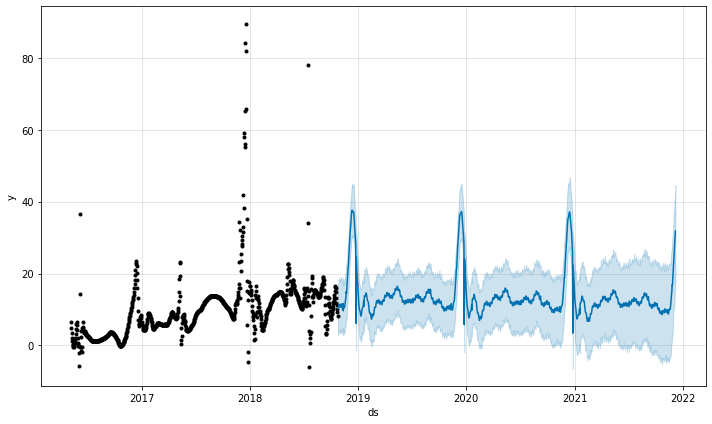

In [14]:
from fbprophet import Prophet
from pandas import to_datetime

#holidays = pd.DataFrame({
#  'holiday': 'playoff',
#  'ds': pd.to_datetime(['2008-01-13', '2009-01-03', '2010-01-16',
#                        '2010-01-24', '2010-02-07', '2011-01-08',
#                        '2013-01-12', '2014-01-12', '2014-01-19',
#                        '2014-02-02', '2015-01-11', '2016-01-17',
#                        '2016-01-24', '2016-02-07']),
#  'lower_window': 0,
#  'upper_window': 1,
#})

#model = Prophet(seasonality_mode='multiplicative') #hoiidays=holidays
model = Prophet() #hoiidays=holidays
model.add_country_holidays(country_name='US')
print("HOLIDAYS LIST:")



model.fit(df_train)
print(model.train_holiday_names)
print("")
print("Train:")
print(df_train.head(6))


future = df_test.iloc[:, 0]
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])


print("")
print("Test:")
print(future.head(6))
forecast = model.predict(future)

print("")
print("Forecast:")
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(6))


fig = model.plot(forecast)


In [15]:
df_var = df_z

df_var['ds'] = pd.to_datetime(df_var['ds'])
weekly_df = df_var.resample('W', on='ds').apply(sum)
monthly_df = df_var.resample('M', on='ds').apply(sum)
daily_df = df_var.resample('D', on='ds').apply(sum)
fig = go.Figure()
fig.add_traces(go.Scatter(x=pd.to_datetime(daily_df.index.values), y = daily_df['y'], mode = 'lines', line=dict(color="royalblue"), name = 'Actual Sales'))
fig.add_traces(go.Scatter(x=forecast['ds'], y = forecast['yhat_upper'], mode = 'lines', line=dict(color="pink"), name = 'Predicted Sales (Upper Bound)'))
fig.add_traces(go.Scatter(x=forecast['ds'], y = forecast['yhat_lower'], fill = 'tonexty', mode = 'lines', line=dict(color="pink"), name = 'Predicted Sales (Lower Bound)'))


fig.add_traces(go.Scatter(x=forecast['ds'], y = forecast['yhat'], mode = 'lines', line=dict(color=colors[1]), name = 'Predicted Sales'))
fig.add_traces(go.Scatter(x=df_train['ds'], y = df_train['y'], mode = 'lines', line=dict(color=colors[2]), name = 'Training data (Denoised)'))

fig.update_layout(title_text='Daily Sales Prediction for Product SKU '+product_name_x, title_x=0.5)

fig.show()

In [16]:
forecast_monthly = forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']].copy()
forecast_monthly.set_index('ds',inplace=True, drop=True)
forecast_monthly = forecast_monthly.resample('M').sum()
print(forecast_monthly)
df_overall_monthly = forecast_monthly.copy()
#fig = go.Figure()
#fig.add_traces(go.Scatter(x=pd.to_datetime(monthly_df.index.values), y = monthly_df['y'], mode = 'lines', line=dict(color="royalblue"), name = 'Actual Sales'))
#fig.add_traces(go.Scatter(x=pd.to_datetime(forecast_monthly.index.values), y = forecast_monthly['yhat_upper'], mode = 'lines', line=dict(color="pink"), name = 'Predicted Sales (Upper Bound)'))
#fig.add_traces(go.Scatter(x=pd.to_datetime(forecast_monthly.index.values), y = forecast_monthly['yhat_lower'], fill = 'tonexty', mode = 'lines', line=dict(color="pink"), name = 'Predicted Sales (Lower Bound)'))

#fig.add_traces(go.Scatter(x=pd.to_datetime(forecast_monthly.index.values), y = forecast_monthly['yhat'], mode = 'lines', line=dict(color="red"), name = 'Predicted Sales'))
#fig.add_traces(go.Scatter(x=df_train['ds'], y = df_train['y'], mode = 'lines', line=dict(color=colors[2]), name = 'Training data'))

#fig.update_layout(title_text='Monthly Sales Prediction for Product SKU '+product_name_x, title_x=0.5)

#fig.show()

                  yhat   yhat_upper  yhat_lower
ds                                             
2018-10-31   76.030235   125.966481   25.584653
2018-11-30  401.609747   617.201088  189.032435
2018-12-31  927.689840  1149.274178  706.480022
2019-01-31  359.898709   581.684518  139.716569
2019-02-28  267.588771   467.559304   66.109318
2019-03-31  373.742455   596.182440  149.840164
2019-04-30  415.721313   631.591338  198.286950
2019-05-31  457.093830   679.003322  235.043481
2019-06-30  365.958660   580.484430  151.213407
2019-07-31  408.190438   631.837770  182.945759
2019-08-31  425.655933   651.430195  197.529917
2019-09-30  378.223342   597.309154  154.385513
2019-10-31  335.973754   564.384478  103.604055
2019-11-30  385.555948   608.215931  159.234068
2019-12-31  915.911997  1148.476196  676.777231
2020-01-31  344.889386   580.712202  103.786916
2020-02-29  265.230799   488.333480   37.521490
2020-03-31  362.387082   603.767911  115.177899
2020-04-30  401.147113   640.618774  156

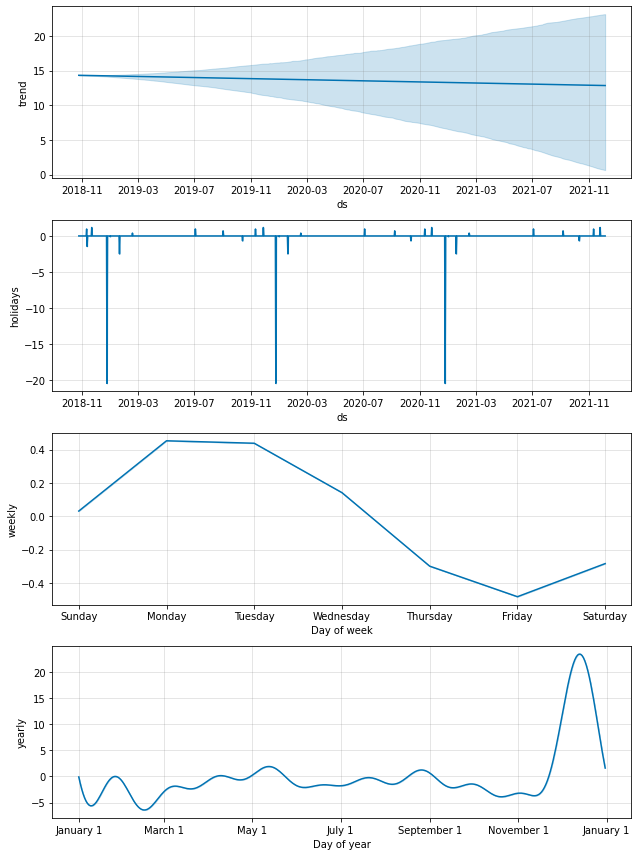

In [17]:
fig = model.plot_components(forecast)

# **Simulating Updating a Fitted Model**


In [18]:
!pip install pystan==2.19.1.1
!pip install prophet

In [19]:
!pip install kaleido


In [26]:
from fbprophet import Prophet
from pandas import to_datetime
from fbprophet import Prophet
import pandas as pd
import time
import numpy as np
import datetime
from datetime import datetime, timedelta
from datetime import datetime
import os
import glob
from PIL import Image
import plotly.express as px

df_z.to_csv("traindate_z.csv")
def stan_init(m):
  res = {}
  for pname in ['k', 'm', 'sigma_obs']:
    res[pname] = m.params[pname][0][0]
  for pname in ['delta', 'beta']:
    res[pname] = m.params[pname][0]
  return res

train_range_start=0   
train_range_end=900
test_range_start=900
 
first_date = test_range_start 
num_days = df_z.iloc[first_date]
print("numdays", num_days['ds'])
num_days_query = num_days['ds']
num_days = num_days_query.days_in_month
print(num_days)
days_left = (num_days_query.replace(day=1) + timedelta(days=32)).replace(day=1)
print("Days left till end of month")
days_left = days_left - num_days_query
days_left = days_left.days - 1
print(days_left)
first_date+=days_left
test_range_start = test_range_start
test_range_end=test_range_start + days_left + 1
print("Training from", df_z.iloc[train_range_start]['ds'], " to ", df_z.iloc[train_range_end]['ds'])
print("Testing from ", df_z.iloc[test_range_start + 1]['ds'], " to ", df_z.iloc[test_range_end - 1]['ds'])

df_train = df_z.iloc[train_range_start:train_range_end,:]
df_test = df_z.iloc[test_range_start:test_range_end,:]
df_test.reset_index(inplace = True, drop = True)


m1 = Prophet(changepoint_prior_scale=0.4) #hoiidays=holidays


m1.add_country_holidays(country_name='US')
print(df_train)
print(df_test)
print("Fitting first time")
m1.fit(df_train)
future = df_test.iloc[:, 0]
future = pd.DataFrame(future)
future.columns = ['ds']
future['ds']= to_datetime(future['ds'])
forecast = m1.predict(future)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head(6))
forecast_monthly = forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']].copy()
forecast_monthly.set_index('ds',inplace=True, drop=True)
forecast_monthly = forecast_monthly.resample('M').sum()

fig = go.Figure()
fig.add_traces(go.Scatter(x=pd.to_datetime(monthly_df.index.values), y = monthly_df['y'], mode = 'lines', line=dict(color="royalblue"), name = 'Actual Sales'))
fig.add_traces(go.Scatter(x=pd.to_datetime(forecast_monthly.index.values), y = forecast_monthly['yhat_upper'], mode = 'lines+markers', marker_symbol='line-ew', marker_line_color="red", marker_color="red",
                           marker_line_width=2, marker_size=10, line=dict(color="pink"), name = 'Predicted Sales (Upper Bound)'))
fig.add_traces(go.Scatter(x=pd.to_datetime(forecast_monthly.index.values), y = forecast_monthly['yhat_lower'], mode = 'lines+markers', marker_symbol='line-ew', marker_line_color="red", marker_color="red",
                           marker_line_width=2, marker_size=10, line=dict(color="pink"), name = 'Predicted Sales (Lower Bound)'))
fig.add_traces(go.Scatter(x=pd.to_datetime(forecast_monthly.index.values), y = forecast_monthly['yhat'], mode = 'lines+markers', line=dict(color="red"), name = 'Predicted Sales'))
fig.add_traces(go.Scatter(x=df_train['ds'], y = df_train['y'], mode = 'lines', line=dict(color=colors[2]), name = 'Training data'))

fig.update_layout(title = dict(text='Monthly Sales Prediction for Product SKU '+product_name_z,x=0.5, font =dict(size=17, color = 'white')))
fig.update_layout(xaxis = {'title':'Year', 'color':'white'}, yaxis = {'title':'Demand', 'color':'white'}, paper_bgcolor='#1c1c28', plot_bgcolor='#28293d')
fig.update_layout(legend_font_color="white")
fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')
fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')
fig.update_layout(autosize=False, width=1013, height=525)
fig.show()

first_date = test_range_start
ctr=0

print("Before loop")
print(train_range_start, train_range_end, test_range_start, test_range_end)

forecast_monthly_history = pd.DataFrame(columns = ['yhat', 'yhat_upper', 'yhat_lower'])
forecast_monthly_history.index = pd.to_datetime(forecast_monthly_history.index)
print("Starting to track prediction history...")

while test_range_end + 30 <= 2039:
  train_range_end = test_range_end - 1
  test_range_start = train_range_end + 1
  num_days = df_z.iloc[test_range_start]
  num_days_query = num_days['ds']
  num_days = num_days_query.days_in_month
  print(num_days)
  test_range_end = test_range_start + num_days
  
  print("Training from", df_z.iloc[train_range_start]['ds'], " to ", df_z.iloc[train_range_end]['ds'])
  print("Testing from ", df_z.iloc[test_range_start]['ds'], " to ", df_z.iloc[test_range_end-1]['ds'])

  df_train = df_z.iloc[train_range_start:train_range_end,:]
  df_test = df_z.iloc[test_range_start:test_range_end,:]
  df_test.reset_index(inplace = True, drop = True)

  #print(df_train.tail(10))

  
  m2 = Prophet(changepoint_prior_scale=0.4)


  m2.add_country_holidays(country_name='US')
  print("Fitting second time")
  if ('02-29') not in str(df_z.iloc[test_range_end-1]['ds']):
    m2.fit(df_train, init=stan_init(m1))
    future = df_test.iloc[:, 0]
    future = pd.DataFrame(future)
    future.columns = ['ds']
    future['ds']= to_datetime(future['ds'])
    forecast = m2.predict(future)
    m1=m2
  else:
    
    
    m1 = Prophet(changepoint_prior_scale=0.4) #hoiidays=holidays


    m1.add_country_holidays(country_name='US')
    m1.fit(df_train)
    future = df_test.iloc[:, 0]
    future = pd.DataFrame(future)
    future.columns = ['ds']
    future['ds']= to_datetime(future['ds'])
    forecast = m1.predict(future)

  forecast_monthly = forecast[['ds', 'yhat', 'yhat_upper', 'yhat_lower']].copy()
  forecast_monthly.set_index('ds',inplace=True, drop=True)
  forecast_monthly = forecast_monthly.resample('M').sum()

  if(forecast_monthly.iloc[0]['yhat'] < 0):
    forecast_monthly.iloc[0]['yhat'] = 0
  if(forecast_monthly.iloc[0]['yhat_upper']<0):
    forecast_monthly.iloc[0]['yhat_upper'] = 0
  if(forecast_monthly.iloc[0]['yhat_lower']<0):
    forecast_monthly.iloc[0]['yhat_lower'] = 0
    forecast_monthly.iloc[0]['yhat'] = (forecast_monthly.iloc[0]['yhat_lower'] + forecast_monthly.iloc[0]['yhat_upper'] ) / 2
  print(forecast_monthly)

  actual_text_date=0
  actual_text_flag = 0
  x=0
  #while actual_text_flag == 0:
  #  print(forecast_monthly.iloc[0].index.values)
  #  print(monthly_df.iloc[x].index.values)
    #if forecast_monthly.iloc[0].index == monthly_df.iloc[x].index:
    #  actual_text_date=monthly_df.iloc[x]['y'] 
    #  actual_text_flag+=1  
  #  x+=1
   #for printing actual sales
  
  fig = go.Figure()
  fig.add_traces(go.Scatter(x=pd.to_datetime(monthly_df.index.values), y = monthly_df['y'], mode = 'lines', line=dict(color="royalblue"), name = 'Actual Sales'))
  
  fig.add_traces(go.Scatter(x=pd.to_datetime(df_overall_monthly.index.values), y = df_overall_monthly['yhat'], mode = 'lines', line=dict(color="sandybrown"), name = 'Predicted Sales (not updating monthly)'))

  fig.add_traces(go.Scatter(x=pd.to_datetime(forecast_monthly.index.values), y = forecast_monthly['yhat_upper'], mode = 'lines+markers', marker_symbol='line-ew', marker_line_color="red", marker_color="red",
                           marker_line_width=2, marker_size=10, line=dict(color="red"), name = 'Predicted Sales Upper Limit (updated monthly)'))
  fig.add_traces(go.Scatter(x=pd.to_datetime(forecast_monthly.index.values), y = forecast_monthly['yhat_lower'], mode = 'lines+markers', marker_symbol='line-ew', marker_line_color="red", marker_color="red",
                           marker_line_width=2, marker_size=10, line=dict(color="pink"), name = 'Predicted Sales Lower Limit (updated monthly)'))


  fig.add_traces(go.Scatter(x=pd.to_datetime(forecast_monthly.index.values), y = forecast_monthly['yhat'], mode = 'lines+markers', line=dict(color="red"), name = 'Predicted Sales (updated monthly)'))
  
  fig.add_traces(go.Scatter(x=df_train['ds'], y = df_train['y'], mode = 'lines', line=dict(color=colors[2]), name = 'Training data'))


  forecast_monthly_history = forecast_monthly_history.append(forecast_monthly)
  print(forecast_monthly_history)

  fig.add_traces(go.Scatter(x=pd.to_datetime(forecast_monthly_history.index.values), y = forecast_monthly_history['yhat'], mode = 'lines', line=dict(color="indianred"), name = 'History'))

  fig.update_layout(title = dict(text='Monthly Sales Prediction for Product SKU '+product_name_z,x=0.5, font =dict(size=17, color = 'white')))
  fig.update_layout(xaxis = {'title':'Year', 'color':'white'}, yaxis = {'title':'Demand', 'color':'white'}, paper_bgcolor='#1c1c28', plot_bgcolor='#28293d')
  fig.update_layout(legend_font_color="white")
  fig.update_layout(width=1013, height=525)
  fig.update_xaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')
  fig.update_yaxes(showline=True, linewidth=2, linecolor='white', gridcolor='#4e4f63')  
  fig.update_xaxes(rangemode="tozero")
  fig.update_yaxes(rangemode="tozero")
  

  predicted_month = forecast_monthly.index.values
  predicted_month = pd.to_datetime(predicted_month)
  predicted_month = predicted_month.strftime('%b')
  
  predicted_month = str(predicted_month)
  predicted_month = predicted_month.replace("Index(['",'')
  predicted_month = predicted_month.replace("'], dtype='object')",'')
  #predicted_month = predicted_month.astype('str')
  print(predicted_month)

  text_sales = forecast_monthly.iloc[0]['yhat']
  text_sales = "Your monthly sales prediction for " + predicted_month + " is " + str(int(text_sales)) + " (" + str(int(forecast_monthly.iloc[0]['yhat_lower'])) + " - " + str(int(forecast_monthly.iloc[0]['yhat_upper'])) + ")"
  fig.add_annotation(dict(font=dict(color='black',size=15),
                                        x=0,
                                        y=-0.15,
                                        showarrow=False,
                                        text=text_sales,
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))
  
  text_sales2 = 100
  text_sales = "Actual sales is " + str(int(text_sales2))
  fig.add_annotation(dict(font=dict(color='black',size=15),
                                        x=0,
                                        y=-0.2,
                                        showarrow=False,
                                        text=text_sales,
                                        textangle=0,
                                        xanchor='left',
                                        xref="paper",
                                        yref="paper"))


  fig.show()
  ctr=ctr+1
  s1 = "frame_folder/fig0"
  s2 = str(ctr)
  s3 = ".png"
  s4=s1+s2+s3
  print(s4)
  fig.write_image(s4)
  if (test_range_end + 30 >= 2039):
    print("INSUFFICIENT DATA TO MAKE A MONTHLY PREDICTION")







INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


numdays 2018-10-25 00:00:00
31
Days left till end of month
6
Training from 2016-05-08 00:00:00  to  2018-10-25 00:00:00
Testing from  2018-10-26 00:00:00  to  2018-10-31 00:00:00
            ds   y
0   2016-05-08   0
1   2016-05-09   0
2   2016-05-10   1
3   2016-05-11   0
4   2016-05-12   0
..         ...  ..
895 2018-10-20  12
896 2018-10-21  16
897 2018-10-22  18
898 2018-10-23  17
899 2018-10-24  13

[900 rows x 2 columns]
          ds   y
0 2018-10-25   9
1 2018-10-26  15
2 2018-10-27  17
3 2018-10-28  11
4 2018-10-29   8
5 2018-10-30  15
6 2018-10-31   6
Fitting first time
          ds       yhat  yhat_lower  yhat_upper
0 2018-10-25   9.783136    2.067153   17.993822
1 2018-10-26   9.888969    1.658507   18.359203
2 2018-10-27   9.100009    1.164965   17.037162
3 2018-10-28  10.302330    2.579776   18.277759
4 2018-10-29  12.311762    4.519008   20.910410
5 2018-10-30  12.709768    4.260296   21.079742


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Before loop
0 900 900 907
Starting to track prediction history...
30
Training from 2016-05-08 00:00:00  to  2018-10-31 00:00:00
Testing from  2018-11-01 00:00:00  to  2018-11-30 00:00:00
Fitting second time
                  yhat  yhat_upper  yhat_lower
ds                                            
2018-11-30  366.794348  616.889906  120.894055
                  yhat  yhat_upper  yhat_lower
2018-11-30  366.794348  616.889906  120.894055
Nov


frame_folder/fig01.png


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


31
Training from 2016-05-08 00:00:00  to  2018-11-30 00:00:00
Testing from  2018-12-01 00:00:00  to  2018-12-31 00:00:00
Fitting second time
                   yhat   yhat_upper  yhat_lower
ds                                              
2018-12-31  2033.738566  2315.420367  1756.54897
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
Dec


frame_folder/fig02.png
31
Training from 2016-05-08 00:00:00  to  2018-12-31 00:00:00
Testing from  2019-01-01 00:00:00  to  2019-01-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat   yhat_upper  yhat_lower
ds                                             
2019-01-31  734.064933  1091.594659  376.082308
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
Jan


frame_folder/fig03.png
28
Training from 2016-05-08 00:00:00  to  2019-01-31 00:00:00
Testing from  2019-02-01 00:00:00  to  2019-02-28 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat  yhat_upper  yhat_lower
ds                                            
2019-02-28  221.007096  442.014192         0.0
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
Feb


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


frame_folder/fig04.png
31
Training from 2016-05-08 00:00:00  to  2019-02-28 00:00:00
Testing from  2019-03-01 00:00:00  to  2019-03-31 00:00:00
Fitting second time
                  yhat  yhat_upper  yhat_lower
ds                                            
2019-03-31  324.466975  648.933949         0.0
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
Mar


frame_folder/fig05.png
30

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Training from 2016-05-08 00:00:00  to  2019-03-31 00:00:00
Testing from  2019-04-01 00:00:00  to  2019-04-30 00:00:00
Fitting second time
                 yhat  yhat_upper  yhat_lower
ds                                           
2019-04-30  307.69747   615.39494         0.0
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
Apr


frame_folder/fig06.png
31
Training from 2016-05-08 00:00:00  to  2019-04-30 00:00:00
Testing from  2019-05-01 00:00:00  to  2019-05-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat  yhat_upper  yhat_lower
ds                                            
2019-05-31  318.275628  636.551256         0.0
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
2019-05-31   318.275628   636.551256     0.000000
May


frame_folder/fig07.png
30
Training from 2016-05-08 00:00:00  to  2019-05-31 00:00:00
Testing from  2019-06-01 00:00:00  to  2019-06-30 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                yhat  yhat_upper  yhat_lower
ds                                          
2019-06-30  312.3311  624.662201         0.0
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
2019-05-31   318.275628   636.551256     0.000000
2019-06-30   312.331100   624.662201     0.000000
Jun


frame_folder/fig08.png
31
Training from 2016-05-08 00:00:00  to  2019-06-30 00:00:00
Testing from  2019-07-01 00:00:00  to  2019-07-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat  yhat_upper  yhat_lower
ds                                            
2019-07-31  278.575336  557.150672         0.0
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
2019-05-31   318.275628   636.551256     0.000000
2019-06-30   312.331100   624.662201     0.000000
2019-07-31   278.575336   557.150672     0.000000
Jul


frame_folder/fig09.png
31
Training from 2016-05-08 00:00:00  to  2019-07-31 00:00:00
Testing from  2019-08-01 00:00:00  to  2019-08-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat  yhat_upper  yhat_lower
ds                                            
2019-08-31  268.292833  536.585667         0.0
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
2019-05-31   318.275628   636.551256     0.000000
2019-06-30   312.331100   624.662201     0.000000
2019-07-31   278.575336   557.150672     0.000000
2019-08-31   268.292833   536.585667     0.000000
Aug


frame_folder/fig010.png
30
Training from 2016-05-08 00:00:00  to  2019-08-31 00:00:00
Testing from  2019-09-01 00:00:00  to  2019-09-30 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat  yhat_upper  yhat_lower
ds                                            
2019-09-30  247.813474  495.626948         0.0
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
2019-05-31   318.275628   636.551256     0.000000
2019-06-30   312.331100   624.662201     0.000000
2019-07-31   278.575336   557.150672     0.000000
2019-08-31   268.292833   536.585667     0.000000
2019-09-30   247.813474   495.626948     0.000000
Sep


frame_folder/fig011.png
31
Training from 2016-05-08 00:00:00  to  2019-09-30 00:00:00
Testing from  2019-10-01 00:00:00  to  2019-10-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                 yhat  yhat_upper  yhat_lower
ds                                           
2019-10-31  273.43714   546.87428         0.0
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
2019-05-31   318.275628   636.551256     0.000000
2019-06-30   312.331100   624.662201     0.000000
2019-07-31   278.575336   557.150672     0.000000
2019-08-31   268.292833   536.585667     0.000000
2019-09-30   247.813474   495.626948     0.000000
2019-10-31   273.437140   546.874280     0.000000
Oct


frame_folder/fig012.png
30
Training from 2016-05-08 00:00:00  to  2019-10-31 00:00:00
Testing from  2019-11-01 00:00:00  to  2019-11-30 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat  yhat_upper  yhat_lower
ds                                            
2019-11-30  509.191923  815.526964  209.782078
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
2019-05-31   318.275628   636.551256     0.000000
2019-06-30   312.331100   624.662201     0.000000
2019-07-31   278.575336   557.150672     0.000000
2019-08-31   268.292833   536.585667     0.000000
2019-09-30   247.813474   495.626948     0.000000
2019-10-31   273.437140   546.874280     0.000000
2019-11-30   509.191923   815.526964   209.782078
Nov


frame_folder/fig013.png
31
Training from 2016-05-08 00:00:00  to  2019-11-30 00:00:00
Testing from  2019-12-01 00:00:00  to  2019-12-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat   yhat_upper   yhat_lower
ds                                               
2019-12-31  1944.668041  2281.344789  1605.098278
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
2019-05-31   318.275628   636.551256     0.000000
2019-06-30   312.331100   624.662201     0.000000
2019-07-31   278.575336   557.150672     0.000000
2019-08-31   268.292833   536.585667     0.000000
2019-09-30   247.813474   495.626948     0.000000
2019-10-31   273.437140   546.874280     0.000000
2019-11-30   509.191923   815.526964   209.782078
2019-12-31  1944.668041  2281.344789  1605.098278
Dec


frame_folder/fig014.png
31
Training from 2016-05-08 00:00:00  to  2019-12-31 00:00:00
Testing from  2020-01-01 00:00:00  to  2020-01-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat   yhat_upper   yhat_lower
ds                                               
2020-01-31  1453.881926  1833.029774  1066.855404
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
2019-05-31   318.275628   636.551256     0.000000
2019-06-30   312.331100   624.662201     0.000000
2019-07-31   278.575336   557.150672     0.000000
2019-08-31   268.292833   536.585667     0.000000
2019-09-30   247.813474   495.626948     0.000000
2019-10-31   273.437140   546.874280     0.000000
2019-11-30   509.191923   815.526964   209.782078
2019-12-31  1944.668041  2281.344789  1605.098278
2020-01-31  1453.881926  1833.029774  1066.855404
Jan


frame_folder/fig015.png
29
Training from 2016-05-08 00:00:00  to  2020-01-31 00:00:00
Testing from  2020-02-01 00:00:00  to  2020-02-29 00:00:00
Fitting second time


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


                  yhat  yhat_upper  yhat_lower
ds                                            
2020-02-29  466.808323  836.687117  104.684623
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
2019-05-31   318.275628   636.551256     0.000000
2019-06-30   312.331100   624.662201     0.000000
2019-07-31   278.575336   557.150672     0.000000
2019-08-31   268.292833   536.585667     0.000000
2019-09-30   247.813474   495.626948     0.000000
2019-10-31   273.437140   546.874280     0.000000
2019-11-30   509.191923   815.526964   209.782078
2019-12-31  1944.668041  2281.344789  1605.098278
2020-01-31  1453.881926  1833.029774  1066.855404
2020-02-29   466.808323   836.687117   104.684623
Feb


frame_folder/fig016.png
31
Training from 2016-05-08 00:00:00  to  2020-02-29 00:00:00
Testing from  2020-03-01 00:00:00  to  2020-03-31 00:00:00
Fitting second time


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


                  yhat  yhat_upper  yhat_lower
ds                                            
2020-03-31  497.977283  886.895344  100.879978
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
2019-05-31   318.275628   636.551256     0.000000
2019-06-30   312.331100   624.662201     0.000000
2019-07-31   278.575336   557.150672     0.000000
2019-08-31   268.292833   536.585667     0.000000
2019-09-30   247.813474   495.626948     0.000000
2019-10-31   273.437140   546.874280     0.000000
2019-11-30   509.191923   815.526964   209.782078
2019-12-31  1944.668041  2281.344789  1605.098278
2020-01-31  1453.881926  1833.029774  1066.855404
2020-02-29   466.808323   836.687117   104.684623
2020-03-3

frame_folder/fig017.png
30
Training from 2016-05-08 00:00:00  to  2020-03-31 00:00:00
Testing from  2020-04-01 00:00:00  to  2020-04-30 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat  yhat_upper  yhat_lower
ds                                            
2020-04-30  386.444437  772.888874         0.0
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
2019-05-31   318.275628   636.551256     0.000000
2019-06-30   312.331100   624.662201     0.000000
2019-07-31   278.575336   557.150672     0.000000
2019-08-31   268.292833   536.585667     0.000000
2019-09-30   247.813474   495.626948     0.000000
2019-10-31   273.437140   546.874280     0.000000
2019-11-30   509.191923   815.526964   209.782078
2019-12-31  1944.668041  2281.344789  1605.098278
2020-01-31  1453.881926  1833.029774  1066.855404
2020-02-29   466.808323   836.687117   

frame_folder/fig018.png
31
Training from 2016-05-08 00:00:00  to  2020-04-30 00:00:00
Testing from  2020-05-01 00:00:00  to  2020-05-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat  yhat_upper  yhat_lower
ds                                             
2020-05-31  1049.661307  1467.56243  629.879899
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
2019-05-31   318.275628   636.551256     0.000000
2019-06-30   312.331100   624.662201     0.000000
2019-07-31   278.575336   557.150672     0.000000
2019-08-31   268.292833   536.585667     0.000000
2019-09-30   247.813474   495.626948     0.000000
2019-10-31   273.437140   546.874280     0.000000
2019-11-30   509.191923   815.526964   209.782078
2019-12-31  1944.668041  2281.344789  1605.098278
2020-01-31  1453.881926  1833.029774  1066.855404
2020-02-29   466.808323   836.687117

frame_folder/fig019.png


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


30
Training from 2016-05-08 00:00:00  to  2020-05-31 00:00:00
Testing from  2020-06-01 00:00:00  to  2020-06-30 00:00:00
Fitting second time
                   yhat   yhat_upper   yhat_lower
ds                                               
2020-06-30  1481.437908  1885.230152  1073.223204
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
2019-05-31   318.275628   636.551256     0.000000
2019-06-30   312.331100   624.662201     0.000000
2019-07-31   278.575336   557.150672     0.000000
2019-08-31   268.292833   536.585667     0.000000
2019-09-30   247.813474   495.626948     0.000000
2019-10-31   273.437140   546.874280     0.000000
2019-11-30   509.191923   815.526964   209.782078
2019-12-3

frame_folder/fig020.png
31
Training from 2016-05-08 00:00:00  to  2020-06-30 00:00:00
Testing from  2020-07-01 00:00:00  to  2020-07-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat   yhat_upper   yhat_lower
ds                                               
2020-07-31  1848.449358  2259.519105  1426.871082
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
2019-05-31   318.275628   636.551256     0.000000
2019-06-30   312.331100   624.662201     0.000000
2019-07-31   278.575336   557.150672     0.000000
2019-08-31   268.292833   536.585667     0.000000
2019-09-30   247.813474   495.626948     0.000000
2019-10-31   273.437140   546.874280     0.000000
2019-11-30   509.191923   815.526964   209.782078
2019-12-31  1944.668041  2281.344789  1605.098278
2020-01-31  1453.881926  1833.029774  1066.855404
2020-02-29   466.808323   836.

frame_folder/fig021.png


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


31
Training from 2016-05-08 00:00:00  to  2020-07-31 00:00:00
Testing from  2020-08-01 00:00:00  to  2020-08-31 00:00:00
Fitting second time
                   yhat   yhat_upper   yhat_lower
ds                                               
2020-08-31  1579.204907  2006.769452  1150.429493
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
2019-05-31   318.275628   636.551256     0.000000
2019-06-30   312.331100   624.662201     0.000000
2019-07-31   278.575336   557.150672     0.000000
2019-08-31   268.292833   536.585667     0.000000
2019-09-30   247.813474   495.626948     0.000000
2019-10-31   273.437140   546.874280     0.000000
2019-11-30   509.191923   815.526964   209.782078
2019-12-3

frame_folder/fig022.png
30
Training from 2016-05-08 00:00:00  to  2020-08-31 00:00:00
Testing from  2020-09-01 00:00:00  to  2020-09-30 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat   yhat_upper   yhat_lower
ds                                               
2020-09-30  1460.929511  1876.185863  1048.479041
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
2019-05-31   318.275628   636.551256     0.000000
2019-06-30   312.331100   624.662201     0.000000
2019-07-31   278.575336   557.150672     0.000000
2019-08-31   268.292833   536.585667     0.000000
2019-09-30   247.813474   495.626948     0.000000
2019-10-31   273.437140   546.874280     0.000000
2019-11-30   509.191923   815.526964   209.782078
2019-12-31  1944.668041  2281.344789  1605.098278
2020-01-31  1453.881926  1833.029774  1066.855404
2020-02-29   466.808323   836.

frame_folder/fig023.png
31
Training from 2016-05-08 00:00:00 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


 to  2020-09-30 00:00:00
Testing from  2020-10-01 00:00:00  to  2020-10-31 00:00:00
Fitting second time
                   yhat   yhat_upper  yhat_lower
ds                                              
2020-10-31  1333.740313  1739.915738  924.088196
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
2019-05-31   318.275628   636.551256     0.000000
2019-06-30   312.331100   624.662201     0.000000
2019-07-31   278.575336   557.150672     0.000000
2019-08-31   268.292833   536.585667     0.000000
2019-09-30   247.813474   495.626948     0.000000
2019-10-31   273.437140   546.874280     0.000000
2019-11-30   509.191923   815.526964   209.782078
2019-12-31  1944.668041  2281.344789  1605.098278

frame_folder/fig024.png


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


30
Training from 2016-05-08 00:00:00  to  2020-10-31 00:00:00
Testing from  2020-11-01 00:00:00  to  2020-11-30 00:00:00
Fitting second time
                   yhat   yhat_upper  yhat_lower
ds                                              
2020-11-30  1657.408405  2052.355899  1263.74739
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
2019-05-31   318.275628   636.551256     0.000000
2019-06-30   312.331100   624.662201     0.000000
2019-07-31   278.575336   557.150672     0.000000
2019-08-31   268.292833   536.585667     0.000000
2019-09-30   247.813474   495.626948     0.000000
2019-10-31   273.437140   546.874280     0.000000
2019-11-30   509.191923   815.526964   209.782078
2019-12-31  

frame_folder/fig025.png
31
Training from 2016-05-08 00:00:00  to  2020-11-30 00:00:00
Testing from  2020-12-01 00:00:00  to  2020-12-31 00:00:00
Fitting second time


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


                   yhat   yhat_upper   yhat_lower
ds                                               
2020-12-31  2682.944315  3121.393072  2245.469826
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
2019-05-31   318.275628   636.551256     0.000000
2019-06-30   312.331100   624.662201     0.000000
2019-07-31   278.575336   557.150672     0.000000
2019-08-31   268.292833   536.585667     0.000000
2019-09-30   247.813474   495.626948     0.000000
2019-10-31   273.437140   546.874280     0.000000
2019-11-30   509.191923   815.526964   209.782078
2019-12-31  1944.668041  2281.344789  1605.098278
2020-01-31  1453.881926  1833.029774  1066.855404
2020-02-29   466.808323   836.687117   104.684623


frame_folder/fig026.png
31
Training from 2016-05-08 00:00:00  to  2020-12-31 00:00:00
Testing from  2021-01-01 00:00:00  to  2021-01-31 00:00:00
Fitting second time


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


                   yhat   yhat_upper   yhat_lower
ds                                               
2021-01-31  3231.650028  3879.433928  2580.663633
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
2019-05-31   318.275628   636.551256     0.000000
2019-06-30   312.331100   624.662201     0.000000
2019-07-31   278.575336   557.150672     0.000000
2019-08-31   268.292833   536.585667     0.000000
2019-09-30   247.813474   495.626948     0.000000
2019-10-31   273.437140   546.874280     0.000000
2019-11-30   509.191923   815.526964   209.782078
2019-12-31  1944.668041  2281.344789  1605.098278
2020-01-31  1453.881926  1833.029774  1066.855404
2020-02-29   466.808323   836.687117   104.684623


frame_folder/fig027.png
28
Training from 2016-05-08 00:00:00  to  2021-01-31 00:00:00
Testing from  2021-02-01 00:00:00  to  2021-02-28 00:00:00
Fitting second time


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


                   yhat   yhat_upper   yhat_lower
ds                                               
2021-02-28  1906.316679  2518.769905  1296.813427
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
2019-05-31   318.275628   636.551256     0.000000
2019-06-30   312.331100   624.662201     0.000000
2019-07-31   278.575336   557.150672     0.000000
2019-08-31   268.292833   536.585667     0.000000
2019-09-30   247.813474   495.626948     0.000000
2019-10-31   273.437140   546.874280     0.000000
2019-11-30   509.191923   815.526964   209.782078
2019-12-31  1944.668041  2281.344789  1605.098278
2020-01-31  1453.881926  1833.029774  1066.855404
2020-02-29   466.808323   836.687117   104.684623


frame_folder/fig028.png
31
Training from 2016-05-08 00:00:00  to  2021-02-28 00:00:00
Testing from  2021-03-01 00:00:00  to  2021-03-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat   yhat_upper  yhat_lower
ds                                              
2021-03-31  1453.699029  2118.396417  782.001955
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
2019-05-31   318.275628   636.551256     0.000000
2019-06-30   312.331100   624.662201     0.000000
2019-07-31   278.575336   557.150672     0.000000
2019-08-31   268.292833   536.585667     0.000000
2019-09-30   247.813474   495.626948     0.000000
2019-10-31   273.437140   546.874280     0.000000
2019-11-30   509.191923   815.526964   209.782078
2019-12-31  1944.668041  2281.344789  1605.098278
2020-01-31  1453.881926  1833.029774  1066.855404
2020-02-29   466.808323   836.687

frame_folder/fig029.png


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


30
Training from 2016-05-08 00:00:00  to  2021-03-31 00:00:00
Testing from  2021-04-01 00:00:00  to  2021-04-30 00:00:00
Fitting second time
                   yhat   yhat_upper  yhat_lower
ds                                              
2021-04-30  1468.626023  2109.067716   820.76957
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
2019-05-31   318.275628   636.551256     0.000000
2019-06-30   312.331100   624.662201     0.000000
2019-07-31   278.575336   557.150672     0.000000
2019-08-31   268.292833   536.585667     0.000000
2019-09-30   247.813474   495.626948     0.000000
2019-10-31   273.437140   546.874280     0.000000
2019-11-30   509.191923   815.526964   209.782078
2019-12-31  

frame_folder/fig030.png
31
Training from 2016-05-08 00:00:00  to  2021-04-30 00:00:00
Testing from  2021-05-01 00:00:00  to  2021-05-31 00:00:00
Fitting second time


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


                   yhat  yhat_upper  yhat_lower
ds                                             
2021-05-31  1187.484509  1844.88566  517.862881
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
2019-05-31   318.275628   636.551256     0.000000
2019-06-30   312.331100   624.662201     0.000000
2019-07-31   278.575336   557.150672     0.000000
2019-08-31   268.292833   536.585667     0.000000
2019-09-30   247.813474   495.626948     0.000000
2019-10-31   273.437140   546.874280     0.000000
2019-11-30   509.191923   815.526964   209.782078
2019-12-31  1944.668041  2281.344789  1605.098278
2020-01-31  1453.881926  1833.029774  1066.855404
2020-02-29   466.808323   836.687117   104.684623
2020-0

frame_folder/fig031.png
30
Training from 2016-05-08 00:00:00  to  2021-05-31 00:00:00
Testing from  2021-06-01 00:00:00  to  2021-06-30 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat  yhat_upper  yhat_lower
ds                                             
2021-06-30  1102.752476  1761.58179  440.426184
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
2019-05-31   318.275628   636.551256     0.000000
2019-06-30   312.331100   624.662201     0.000000
2019-07-31   278.575336   557.150672     0.000000
2019-08-31   268.292833   536.585667     0.000000
2019-09-30   247.813474   495.626948     0.000000
2019-10-31   273.437140   546.874280     0.000000
2019-11-30   509.191923   815.526964   209.782078
2019-12-31  1944.668041  2281.344789  1605.098278
2020-01-31  1453.881926  1833.029774  1066.855404
2020-02-29   466.808323   836.687117

frame_folder/fig032.png
31
Training from 2016-05-08 00:00:00  to  2021-06-30 00:00:00
Testing from  2021-07-01 00:00:00  to  2021-07-31 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                   yhat   yhat_upper  yhat_lower
ds                                              
2021-07-31  1021.301889  1714.208923  329.775116
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
2019-05-31   318.275628   636.551256     0.000000
2019-06-30   312.331100   624.662201     0.000000
2019-07-31   278.575336   557.150672     0.000000
2019-08-31   268.292833   536.585667     0.000000
2019-09-30   247.813474   495.626948     0.000000
2019-10-31   273.437140   546.874280     0.000000
2019-11-30   509.191923   815.526964   209.782078
2019-12-31  1944.668041  2281.344789  1605.098278
2020-01-31  1453.881926  1833.029774  1066.855404
2020-02-29   466.808323   836.687

frame_folder/fig033.png
31
Training from 2016-05-08 00:00:00  to  2021-07-31 00:00:00
Testing from  2021-08-01 00:00:00  to  2021-08-31 00:00:00
Fitting second time


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


                  yhat  yhat_upper  yhat_lower
ds                                            
2021-08-31  824.246895  1503.34212  140.961928
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
2019-05-31   318.275628   636.551256     0.000000
2019-06-30   312.331100   624.662201     0.000000
2019-07-31   278.575336   557.150672     0.000000
2019-08-31   268.292833   536.585667     0.000000
2019-09-30   247.813474   495.626948     0.000000
2019-10-31   273.437140   546.874280     0.000000
2019-11-30   509.191923   815.526964   209.782078
2019-12-31  1944.668041  2281.344789  1605.098278
2020-01-31  1453.881926  1833.029774  1066.855404
2020-02-29   466.808323   836.687117   104.684623
2020-03-3

frame_folder/fig034.png
30
Training from 2016-05-08 00:00:00  to  2021-08-31 00:00:00
Testing from  2021-09-01 00:00:00  to  2021-09-30 00:00:00
Fitting second time


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


                  yhat   yhat_upper  yhat_lower
ds                                             
2021-09-30  805.146961  1468.220391  141.943395
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
2019-05-31   318.275628   636.551256     0.000000
2019-06-30   312.331100   624.662201     0.000000
2019-07-31   278.575336   557.150672     0.000000
2019-08-31   268.292833   536.585667     0.000000
2019-09-30   247.813474   495.626948     0.000000
2019-10-31   273.437140   546.874280     0.000000
2019-11-30   509.191923   815.526964   209.782078
2019-12-31  1944.668041  2281.344789  1605.098278
2020-01-31  1453.881926  1833.029774  1066.855404
2020-02-29   466.808323   836.687117   104.684623
2020-0

frame_folder/fig035.png


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


31
Training from 2016-05-08 00:00:00  to  2021-09-30 00:00:00
Testing from  2021-10-01 00:00:00  to  2021-10-31 00:00:00
Fitting second time
                  yhat   yhat_upper  yhat_lower
ds                                             
2021-10-31  870.898637  1547.517987  202.592872
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
2019-05-31   318.275628   636.551256     0.000000
2019-06-30   312.331100   624.662201     0.000000
2019-07-31   278.575336   557.150672     0.000000
2019-08-31   268.292833   536.585667     0.000000
2019-09-30   247.813474   495.626948     0.000000
2019-10-31   273.437140   546.874280     0.000000
2019-11-30   509.191923   815.526964   209.782078
2019-12-31  194

frame_folder/fig036.png
30
Training from 2016-05-08 00:00:00  to  2021-10-31 00:00:00
Testing from  2021-11-01 00:00:00  to  2021-11-30 00:00:00


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting second time
                  yhat   yhat_upper  yhat_lower
ds                                             
2021-11-30  1623.76984  2276.357877  984.949601
                   yhat   yhat_upper   yhat_lower
2018-11-30   366.794348   616.889906   120.894055
2018-12-31  2033.738566  2315.420367  1756.548970
2019-01-31   734.064933  1091.594659   376.082308
2019-02-28   221.007096   442.014192     0.000000
2019-03-31   324.466975   648.933949     0.000000
2019-04-30   307.697470   615.394940     0.000000
2019-05-31   318.275628   636.551256     0.000000
2019-06-30   312.331100   624.662201     0.000000
2019-07-31   278.575336   557.150672     0.000000
2019-08-31   268.292833   536.585667     0.000000
2019-09-30   247.813474   495.626948     0.000000
2019-10-31   273.437140   546.874280     0.000000
2019-11-30   509.191923   815.526964   209.782078
2019-12-31  1944.668041  2281.344789  1605.098278
2020-01-31  1453.881926  1833.029774  1066.855404
2020-02-29   466.808323   836.687117

frame_folder/fig037.png
INSUFFICIENT DATA TO MAKE A MONTHLY PREDICTION


In [21]:
!pip freeze > requirements.txt


In [27]:
def make_gif(frame_folder):
    frames = [Image.open(image) for image in glob.glob(f"{frame_folder}/*.png")]
    frame_one = frames[0]
    frame_one.save("results_6.gif", format="GIF", append_images=frames,
               save_all=True, duration=1000, loop=0)
    
make_gif("frame_folder")

In [23]:
import plotly.express as px
df = px.data.iris()
fig = px.scatter(
        df, x="sepal_width", y="sepal_length", color="species"
)
fig.write_image("fig.png")

In [24]:
!pip install plotly==5.5.0


In [25]:
!pip list

Package                       Version
----------------------------- --------------
absl-py                       0.12.0
alabaster                     0.7.12
albumentations                0.1.12
altair                        4.1.0
appdirs                       1.4.4
argcomplete                   1.12.3
argon2-cffi                   21.1.0
arviz                         0.11.4
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
atari-py                      0.2.9
atomicwrites                  1.4.0
attrs                         21.2.0
audioread                     2.1.9
autograd                      1.3
Babel                         2.9.1
backcall                      0.2.0
beautifulsoup4                4.6.3
bleach                        4.1.0
blis                          0.4.1
bokeh                         2.3.3
Bottleneck                    1.3.2
branca                        0.4.2
bs4                           0.0.1
CacheControl